# 横浜市における新型コロナ陽性患者の分析2022/1
<a id="table_of_contents"></a>
## 目次

1. [イントロダクション](#introduction)
2. [前処理](#preprocessing)
3. [感染者数](#infected)
4. [死亡率](#death rate)
5. [年代](#age)

<a id="introduction"></a>
# 1. イントロダクション

日本でコロナウイルスが初めて確認された2020年3月からオミクロン株が流行している2022年1月までのコロナ陽性患者の性質を見る．  
横浜市が公表している新型コロナウイルス感染症関連オープンデータより「陽性患者一覧」を使用した．  
（https://www.city.yokohama.lg.jp/kurashi/kenko-iryo/yobosesshu/kansensho/coronavirus/corona-data.html  ，ダウンロード日：2022/1/31）

<a id="preprocessing"></a>
# 2. 前処理

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import japanize_matplotlib
import seaborn as sns
import datetime as dt

%matplotlib inline

In [2]:
patients_yoko = pd.read_csv('yokohama_covid19_patients.csv')
patients_yoko.head()

C:\Users\shun_k\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (7,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,記者発表Ｎｏ,全国地方自治体コード,都道府県名,市町村名,記者発表日,年代,性別,住所地,感染経路,確定時病状,直近状況,ワクチン接種完了
0,1,141003,神奈川県,横浜市,2020-02-18,60代,男,NaN,不明,中等症,NaN,NaN
1,2,141003,神奈川県,横浜市,2020-02-20,60代,女,NaN,NaN,無症状,NaN,NaN
2,3,141003,神奈川県,横浜市,2020-02-21,30代,女,NaN,NaN,軽症,NaN,NaN
3,4,141003,神奈川県,横浜市,2020-02-28,50代,男,NaN,NaN,重症,NaN,NaN
4,5,141003,神奈川県,横浜市,2020-03-03,20代,女,NaN,NaN,軽症,NaN,NaN


In [3]:
df = patients_yoko.copy()
# 列の削除とrename
df = df.drop(['記者発表Ｎｏ', '全国地方自治体コード', '都道府県名', '市町村名','住所地','感染経路'], axis=1)
# datetime型
df['記者発表日'] = pd.to_datetime(df['記者発表日'])
# 週ごと
df["週"] = df["記者発表日"].dt.to_period("W").dt.to_timestamp()
# 日ごと
df["日"] = df["記者発表日"].dt.to_period("D").dt.to_timestamp()
# 月ごと
df["月"] = df["記者発表日"].dt.to_period("M").dt.to_timestamp()
# 年代
df = df[~(df['年代']=='非公表')]
df = df[~(df['年代']=='調査中')]
df = df[~(df['年代']=='不明')]
# 性別・ワクチン接種完了
df = df[~(df['性別']=='非公表')]
df = df[~(df['性別']=='調査中')]
df = df[~(df['性別']=='不明')]
df = df.replace('男','男性')
df = df.replace('女','女性')
df = pd.get_dummies(df,columns={'性別','ワクチン接種完了'})
df.rename(columns={'性別_男性': '男性', '性別_女性': '女性'}, inplace=True)
df.rename(columns={'ワクチン接種完了_有': '有', 'ワクチン接種完了_無': '無'}, inplace=True)
# 直近状況
df.rename(columns={'直近状況': '生死'}, inplace=True)
df.replace({'生死': {None:0,'死亡':1}},inplace=True)

df = df[df['記者発表日'] >= '20200401']

df

,記者発表日,年代,確定時病状,生死,週,日,月,女性,男性,有,無
19,2020-04-03,10歳未満,軽症,0,2020-03-30,2020-04-03,2020-04-01,1,0,0,0
30,2020-04-01,20代,軽症,0,2020-03-30,2020-04-01,2020-04-01,1,0,0,0
31,2020-04-02,30代,軽症,0,2020-03-30,2020-04-02,2020-04-01,1,0,0,0
32,2020-04-02,20代,軽症,0,2020-03-30,2020-04-02,2020-04-01,1,0,0,0
33,2020-04-02,50代,軽症,0,2020-03-30,2020-04-02,2020-04-01,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
79833,2022-01-23,20代,軽症,0,2022-01-17,2022-01-23,2022-01-01,0,1,0,1
79834,2022-01-23,50代,軽症,0,2022-01-17,2022-01-23,2022-01-01,1,0,0,1
79835,2022-01-23,10代,軽症,0,2022-01-17,2022-01-23,2022-01-01,1,0,0,1
79836,2022-01-23,10代,軽症,0,2022-01-17,2022-01-23,2022-01-01,0,1,0,1


[目次に戻る](#table_of_contents)
<a id="preprocessing"></a>
# 3. 感染者数

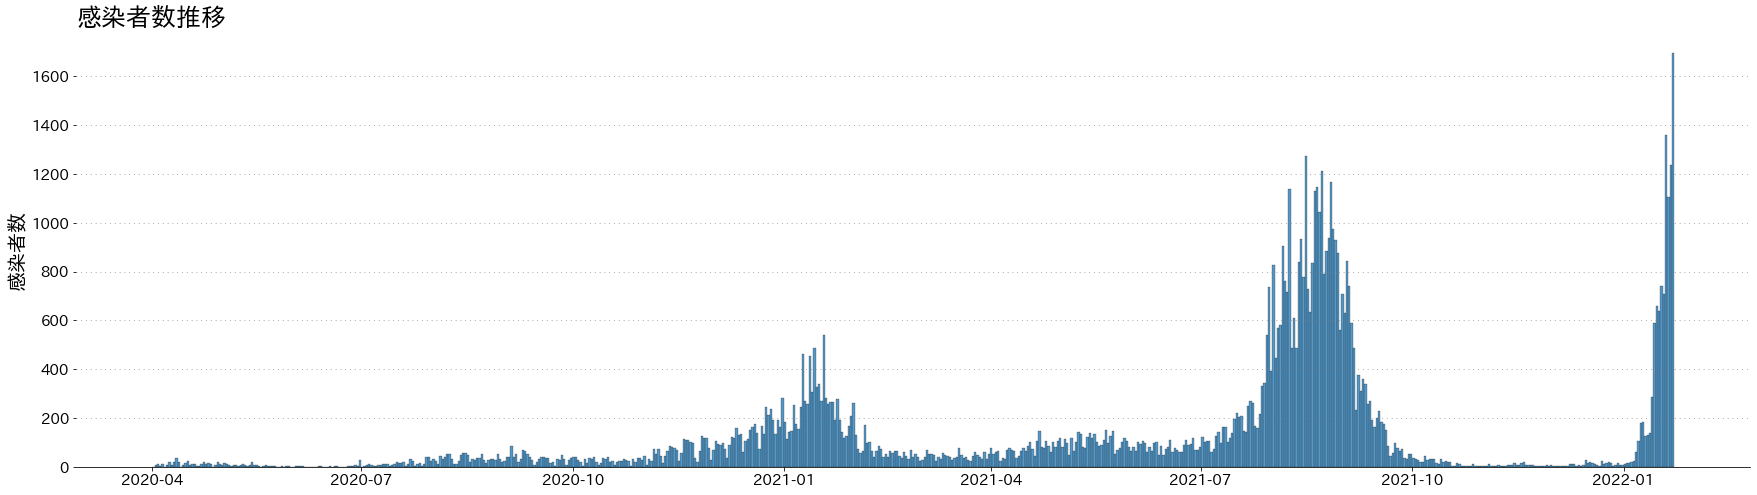

In [4]:
plt.figure(figsize=(30,8))
bins_max=df['記者発表日'].max()-df['記者発表日'].min()
bins_max=bins_max.days+1
sns.histplot(data=df,x='記者発表日',bins=bins_max,)
plt.title('感染者数推移',loc='left',fontsize=25)
plt.xlabel('')
plt.ylabel("感染者数", fontsize = 20)
plt.tick_params(labelsize = 15)
for s in ['right','left','top']:
    plt.gca().spines[s].set_visible(False)
plt.grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(1,5))



In [5]:
import itertools

def plot_stacked_bar_chart(data, x, y='y', hue='hue', rational=False, axis=0,width=5):
    # 横持ちのデータは縦持ちに変換
    if axis:
        data = data.set_index(x)
        data = data.stack().reset_index().rename(columns={'level_1': hue, 0: y})

    groups = np.sort(data[hue].unique())
    x_vals = np.sort(data[x].unique())
    pair = pd.DataFrame(list(map(list, itertools.product(x_vals, groups))), columns=[x, hue])
    data = pair.merge(data, on=[x, hue], how='left').fillna(0)

    # 割合を算出
    if rational:
        col_name = f'__sum_{y}'
        sum_y_by_x = data.groupby(x)[y].sum().reset_index().rename(columns={y: col_name})
        data = data.merge(sum_y_by_x, on=x, how='left')
        data[f'{y}_ratio'] = data[y] / data[col_name]
        target_col_name = f'{y}_ratio'
    else:
        target_col_name = y

    n = len(data[x].unique())
    bottom_values = np.zeros(shape=(n,))
    for group in groups:
        tmp_df = data[data[hue] == group]
        plt.bar(tmp_df[x], tmp_df[target_col_name], bottom=bottom_values, label=group, width=width)
        bottom_values += tmp_df[target_col_name].values

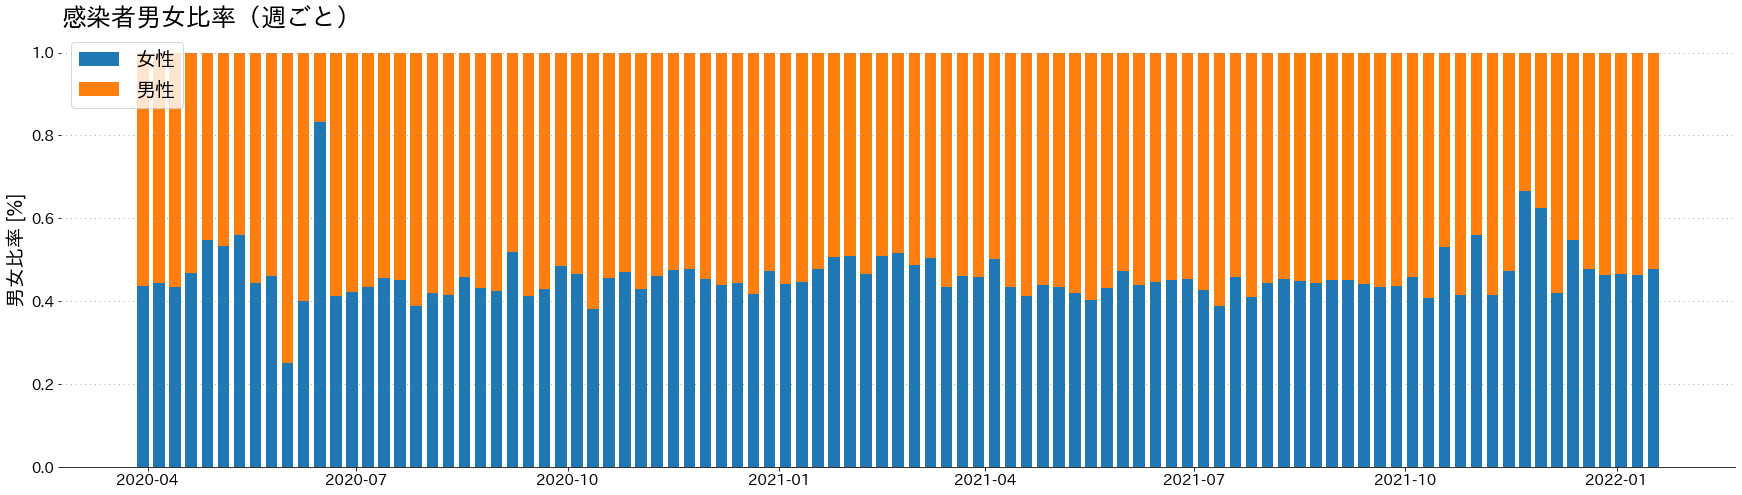

In [6]:
temp = df.groupby('週')[['女性','男性']].sum()
temp = temp.stack().reset_index()
temp.columns = ['日','性別',"人数"]
plt.figure(figsize=(30,8))
plt.title('感染者男女比率（週ごと）',loc='left',fontsize=25)
plt.xlabel("", fontsize = 20)
plt.ylabel("男女比率 [%]", fontsize = 20)
plt.tick_params(labelsize = 15)
for s in ['right','left','top']:
    plt.gca().spines[s].set_visible(False)
plt.grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(1,5))
plot_stacked_bar_chart(data=temp, x='日', y='人数', hue='性別', rational=True, width=5)
plt.legend(fontsize=20, loc='upper left')

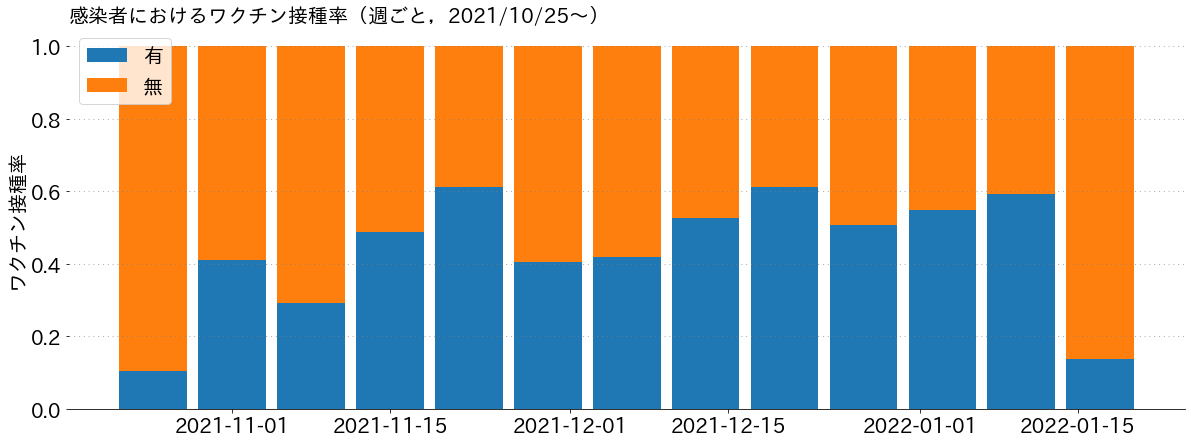

In [7]:
temp = df[(df['有'] == 1) | (df['無'] == 1)]
temp = temp.groupby('週')[['有','無']].sum()
temp = temp.stack().reset_index()
temp.columns = ['週','ワクチン接種有無',"人数"]
plt.figure(figsize=(20,7))
plt.title('感染者におけるワクチン接種率（週ごと，2021/10/25～）',loc='left',fontsize=20)
plt.ylabel("ワクチン接種率", fontsize = 20)
plt.tick_params(labelsize = 20)
for s in ['right','left','top']:
    plt.gca().spines[s].set_visible(False)
plt.grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(1,5))
plot_stacked_bar_chart(data=temp, x='週', y='人数', hue='ワクチン接種有無', rational=True, width=6)
plt.legend(fontsize=20, loc='upper left')

[目次に戻る](#table_of_contents)
<a id="death rate"></a>
# 4. 死亡率

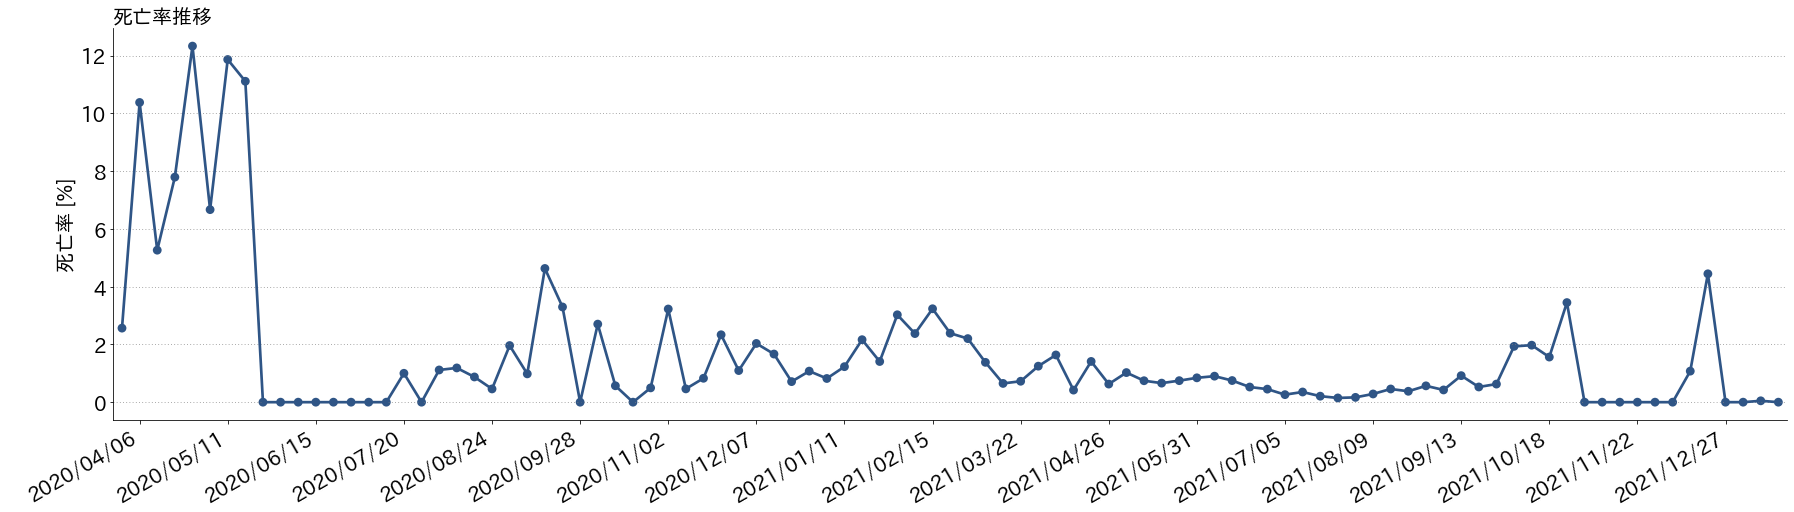

In [8]:
temp = pd.concat([df.groupby('週')['生死'].sum(),df.groupby('週')['生死'].count()], axis=1).reset_index()
temp.columns = ['週','死者','陽性者']
temp['週'] = temp['週'].dt.strftime('%Y/%m/%d')
temp['死亡率'] = temp['死者'] / temp['陽性者'] * 100
plt.figure(figsize=(30,8))
ax = sns.pointplot(x='週', y='死亡率', data=temp,color='#2f5586')
plt.title('死亡率推移',loc='left',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('死亡率 [%]',fontsize=20)
plt.xlabel('',fontsize=20)
plt.gcf().autofmt_xdate()

for s in ['right','top']:
    plt.gca().spines[s].set_visible(False)
plt.grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(1,3))

xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i%5!=1:
        xticks[i].set_visible(False)

plt.show()

### 年代別死亡率

In [9]:
temp = df.groupby('年代')['生死'].value_counts().unstack()
temp.fillna(0, inplace=True)
temp.reset_index(inplace=True)
temp = temp.reindex([1,0,2,3,4,5,6,7,8,9], axis='index')
temp.reset_index(drop=True,inplace=True)
temp.columns = ['年代','陽性者','死者']
temp.dropna(0,inplace=True)
temp['死亡率 [%]'] = round(temp['死者'] / temp['陽性者'] * 100,3)
temp

,年代,陽性者,死者,死亡率 [%]
0,10歳未満,4724.0,0.0,0.000
1,10代,8567.0,1.0,0.012
2,20代,19553.0,1.0,0.005
3,30代,12555.0,5.0,0.040
4,40代,12354.0,11.0,0.089
5,50代,10855.0,23.0,0.212
6,60代,4599.0,49.0,1.065
7,70代,3266.0,130.0,3.980
8,80代,2007.0,223.0,11.111
9,90歳以上,728.0,137.0,18.819


Text(0.5, 0, '')

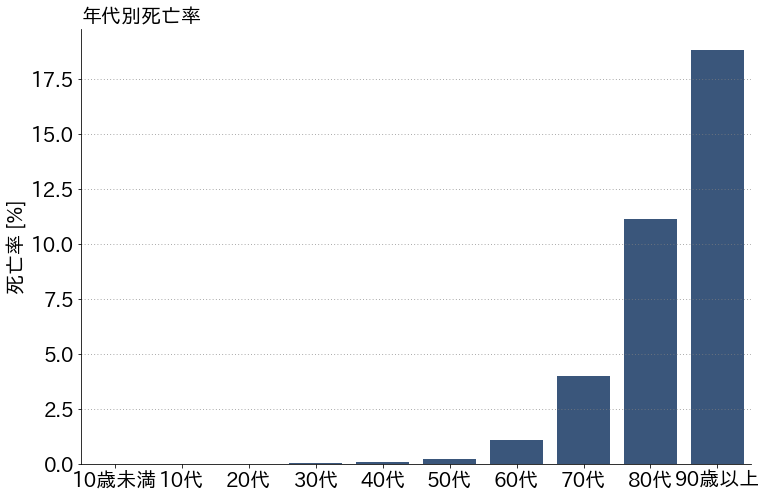

In [10]:
plt.figure(figsize=(12,8))
for s in ['right','top']:
    plt.gca().spines[s].set_visible(False)
plt.grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(1,3))
sns.barplot(data=temp,x='年代',y='死亡率 [%]', color='#2f5586')
plt.title('年代別死亡率',loc='left',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('死亡率 [%]',fontsize=20)
plt.xlabel('',fontsize=20)

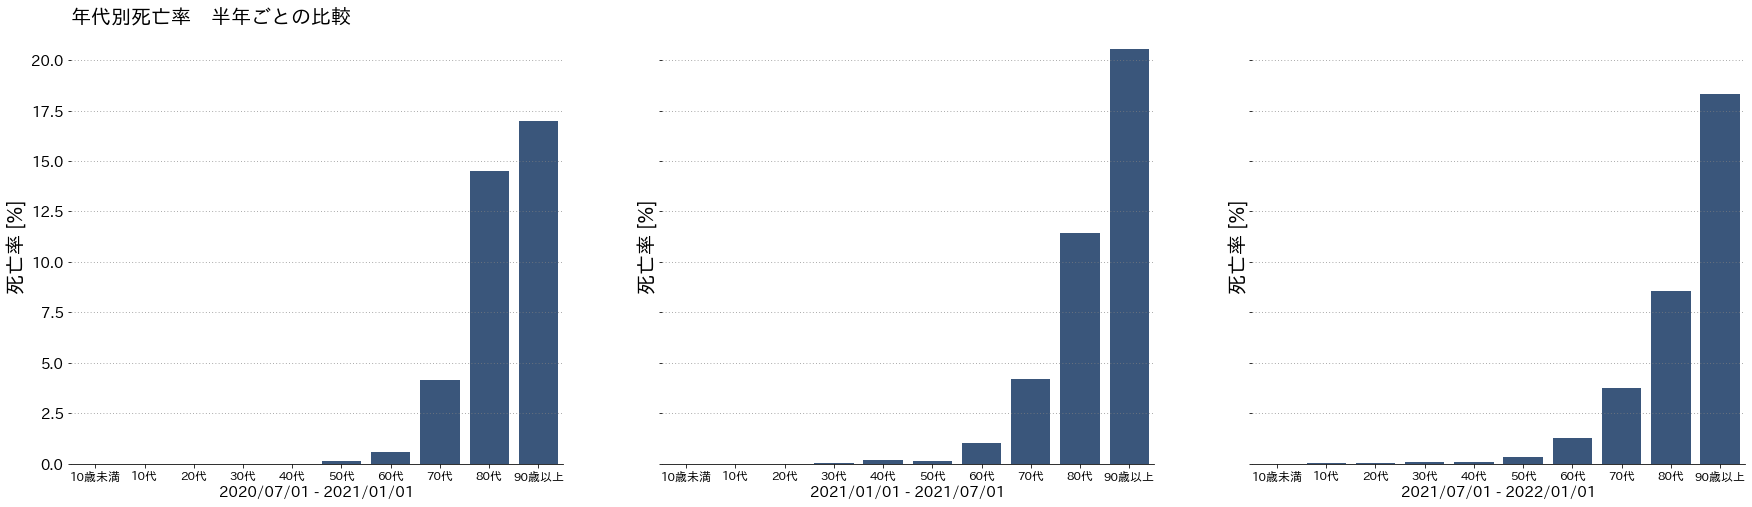

In [11]:
def proccecing(temp):
    temp = temp.groupby('年代')['生死'].value_counts().unstack()
    temp.fillna(0, inplace=True)
    temp.reset_index(inplace=True)
    temp = temp.reindex([1,0,2,3,4,5,6,7,8,9], axis='index')
    temp.reset_index(drop=True,inplace=True)
    temp.columns = ['年代','陽性者','死者']
    temp.dropna(0,inplace=True)
    temp['死亡率 [%]'] = round(temp['死者'] / temp['陽性者'] * 100,3)
    return temp

list = ['2020/07/01','2021/01/01','2021/07/01','2022/01/01']

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(30,8),sharey=True)
ax0.set_title('年代別死亡率　半年ごとの比較',loc='left',fontsize=20)

run_no = 0
for i in range(len(list) - 1):
    temp = df[(df['記者発表日'] >= list[i]) & (df['記者発表日'] < list[i + 1])]
    temp = proccecing(temp)
    for s in ["top","right", 'left']:
        locals()["ax"+str(run_no)].spines[s].set_visible(False)
    sns.barplot(data=temp,x='年代',y='死亡率 [%]', color='#2f5586', ax=locals()["ax"+str(run_no)])
    locals()["ax"+str(run_no)].set_ylabel('死亡率 [%]',fontsize=20)
    locals()["ax"+str(run_no)].tick_params(axis='x', labelsize=12)
    locals()["ax"+str(run_no)].tick_params(axis='y', labelsize=15)
    locals()["ax"+str(run_no)].set_xlabel(str(list[i])+' - '+str(list[i+1]), fontsize=15)
    locals()["ax"+str(run_no)].grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(1,3))

    run_no += 1

[目次に戻る](#table_of_contents)
<a id="age"></a>
# 5. 年代

<AxesSubplot:title={'left':'年代ごとの確定時病状割合'}, xlabel='確定時病状', ylabel='年代'>

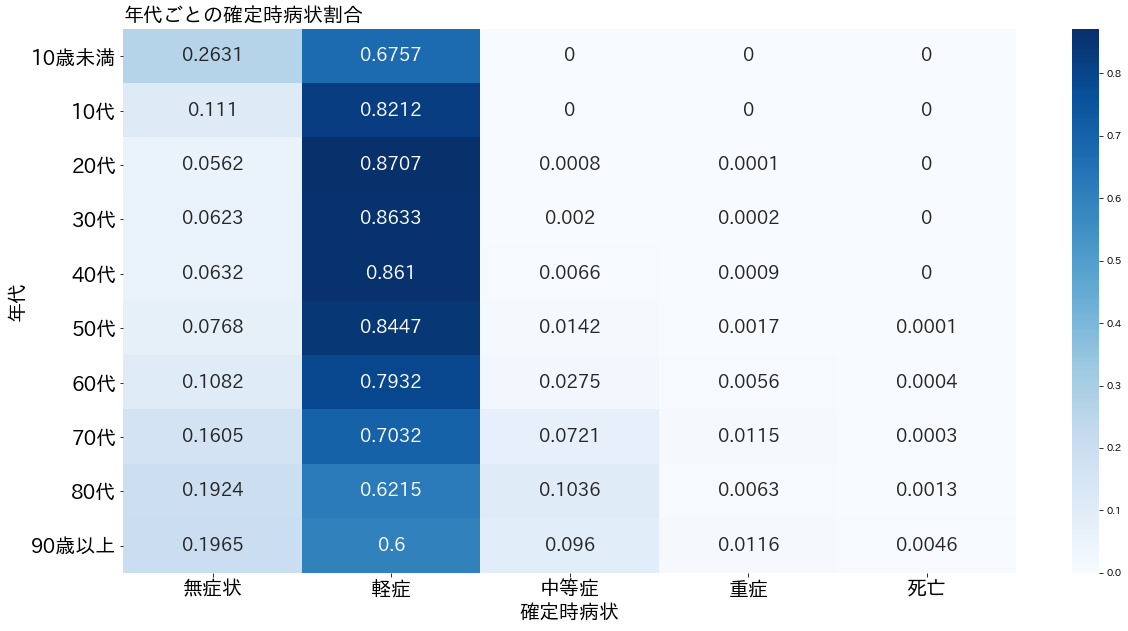

In [12]:
df['count'] = 1
temp = pd.pivot_table(data=df, index='年代', columns='確定時病状', values='count',aggfunc='sum', margins=True)
temp.fillna(0, inplace=True)
for col in temp.columns:
    temp[col] = temp[col] / temp['All']
temp.drop('All', axis=1, inplace=True)
temp = round(temp, 4)
temp = temp.reindex(columns=['無症状', '軽症','中等症','重症','死亡'])
temp = temp.reindex(index=['10歳未満', '10代','20代','30代','40代','50代','60代','70代','80代','90歳以上'])
plt.figure(figsize=(20, 10))
plt.xlabel('確定時病状',fontsize=20)
plt.ylabel('年代',fontsize=20)
plt.title('年代ごとの確定時病状割合',loc='left',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20, rotation=90)
sns.heatmap(temp, annot=True, fmt='g', annot_kws={"size":18} , cmap='Blues')

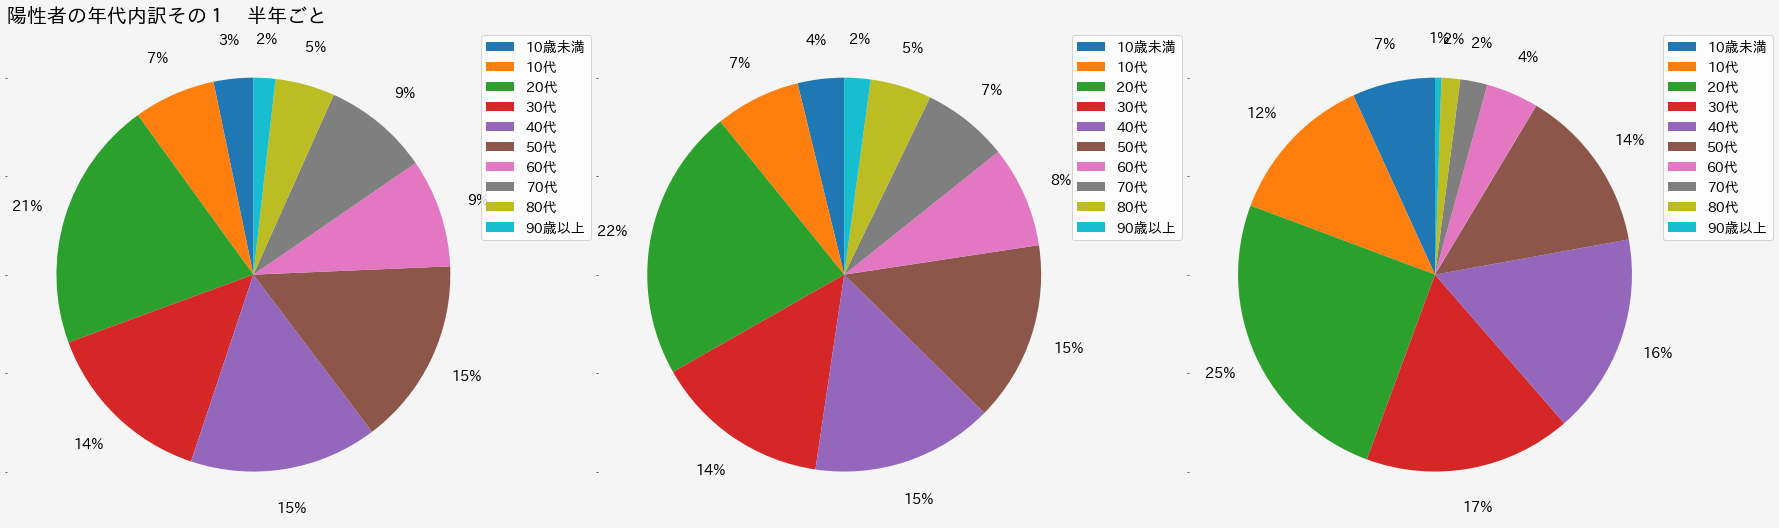

In [13]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(30,10),sharey=True, facecolor='#f6f5f5')
ax0.set_title('陽性者の年代内訳その１　半年ごと',loc='left',fontsize=20)
ax0.set_facecolor("white")
# label = temp['年代'].tolist()

# temp.plot.pie(y='割合', labels=label, ax=ax1)
list = ['2020/07/01','2021/01/01','2021/07/01','2022/01/01']
run_no = 0
for i in range(len(list) - 1):
    temp = df[(df['記者発表日'] >= list[i]) & (df['記者発表日'] < list[i + 1])]
    temp = temp['年代'].value_counts(normalize=True).reset_index()
    temp.columns = ['年代','割合']
    temp['割合'] = temp['割合'] * 100
    temp['割合'] = round(temp['割合'], 2)
    temp.index = temp['年代']
    temp = temp.reindex(index=['10歳未満', '10代','20代','30代','40代','50代','60代','70代','80代','90歳以上'])
    temp.reset_index(drop=True, inplace=True)
    label = temp['年代'].tolist()
    temp.plot.pie(y='割合',labels=['','','','','','','','','',''],pctdistance=1.2, startangle=90 ,ax=locals()["ax"+str(run_no)], autopct='%1.0f%%',textprops={'size': 'x-large'})
    locals()["ax"+str(run_no)].legend(labels=label, fontsize=14, loc='upper right',bbox_to_anchor=(1.2, 1))
    locals()["ax"+str(run_no)].set_ylabel('',fontsize=20)
    locals()["ax"+str(run_no)].set_xlabel('')

    run_no += 1

plt.rcParams['font.size'] = 10 # ラベルテキストのサイズ設定

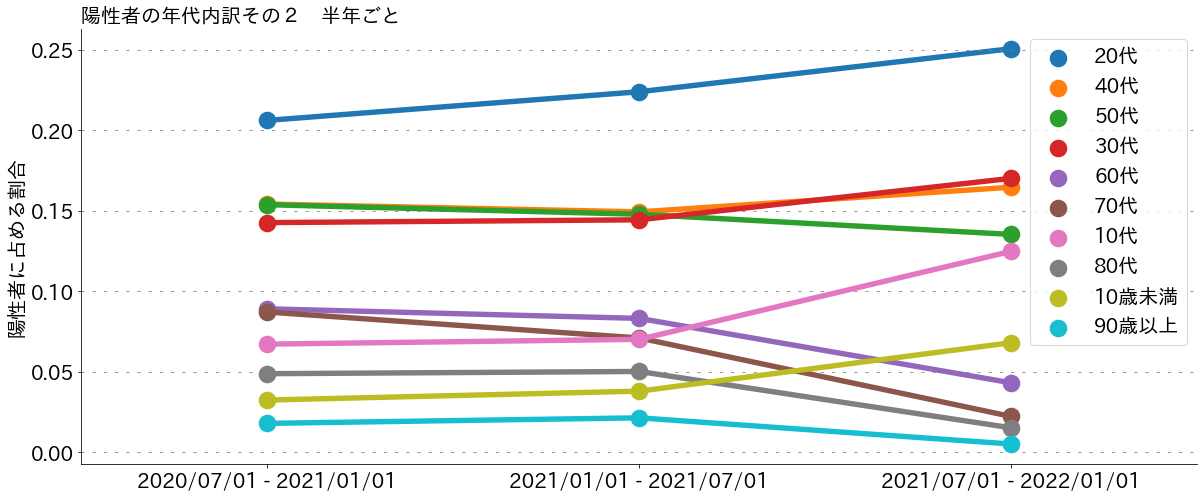

In [14]:
list = ['2020/07/01','2021/01/01','2021/07/01','2022/01/01']
df_master = pd.DataFrame()

for i in range(len(list) - 1):
    temp = df[(df['記者発表日'] >= list[i]) & (df['記者発表日'] < list[i + 1])]
    temp = temp['年代'].value_counts(normalize=True).reset_index().T
    temp.columns = temp.iloc[0].tolist()
    temp.drop(temp.index[0], inplace=True)
    temp.index = [str(list[i])+' - '+str(list[i+1])]
    df_master = pd.concat([df_master, temp])

df_master = df_master.stack().reset_index()
df_master.columns = ['期間','年代','割合']


plt.figure(figsize=(20, 8))
sns.pointplot(data=df_master ,x='期間', y ='割合', hue='年代',scale=2)
plt.title('陽性者の年代内訳その２　半年ごと',loc='left',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('陽性者に占める割合',fontsize=20)
plt.xlabel('',fontsize=20)
for s in ['right','top']:
    plt.gca().spines[s].set_visible(False)
plt.grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(4,10))
plt.legend(fontsize=20)